In [2]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [3]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [4]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_2.5s_0.05s.pt')
target_tensors = torch.load('target_tensors_2.5s_0.05s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([50, 22])
Shape of target tensor: torch.Size([3000])


In [5]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [6]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
model.load_state_dict(torch.load('model_weights_2.5s_0.05s.pt'))

# at 3250 total so far
num_epochs = 5_000

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)

        prev_loss = average_loss


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 125, Loss: 4.0245:   2%|▎         | 125/5000 [00:14<09:41,  8.39it/s]


KeyboardInterrupt: 

In [9]:
model.load_state_dict(torch.load('model_weights_2.5s_0.05s.pt'))

<All keys matched successfully>

In [ ]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_2.5s_0.05s.pt')

NameError: name 'torch' is not defined

In [10]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total absolute error
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.1772170498802249


In [11]:
# Initialize variables to calculate total absolute error for denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value and denormalize it
        predicted_value = denormalize(model(input_tensor).item())
        actual_value = denormalize(target_value.item())

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 20.02080535888672


In [12]:
# Initialize list to store absolute errors
absolute_errors = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error and append to list
        absolute_error = abs(predicted_value - actual_value)
        absolute_errors.append(absolute_error)

# Calculate median absolute error
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.03307434916496277


In [13]:
# get the median absolute error for the denormalized values
absolute_errors = []

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 3.736520767211914


In [14]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0).to(device)).item()
    actual_value = test_targets[i].to(device).item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.4879683642374907


In [15]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 6227.93212890625


In [16]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].to(device).unsqueeze(0)).item()
    actual_value = test_targets[i].to(device).item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.25956231355667114, Predicted: -0.23234426975250244
Actual: -0.21076713502407074, Predicted: -0.17646265029907227
Actual: -0.25311535596847534, Predicted: -0.23853850364685059
Actual: -0.25894051790237427, Predicted: -0.2419208288192749
Actual: -0.18805654346942902, Predicted: -0.20943808555603027
Actual: -0.1525583416223526, Predicted: -0.19790005683898926
Actual: -0.25685393810272217, Predicted: -0.24038171768188477
Actual: -0.2239244431257248, Predicted: -0.13687705993652344
Actual: -0.24534101784229279, Predicted: -0.21408605575561523
Actual: -0.24977101385593414, Predicted: -0.2139418125152588
Actual: -0.1498592644929886, Predicted: -0.14238214492797852
Actual: -0.2587216794490814, Predicted: -0.23700356483459473
Actual: 0.059361573308706284, Predicted: 0.3439137935638428
Actual: -0.23894771933555603, Predicted: -0.2046501636505127
Actual: -0.02872498892247677, Predicted: 0.05419158935546875
Actual: -0.19288115203380585, Predicted: -0.1945631504058838
Actual: -0.15428712

In [17]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: 0.2448253631591797, Predicted: 3.3197383880615234
Actual: 5.757381439208984, Predicted: 9.63287353515625
Actual: 0.9731597900390625, Predicted: 2.619955062866211
Actual: 0.31507110595703125, Predicted: 2.237842559814453
Actual: 8.32307243347168, Predicted: 5.907527923583984
Actual: 12.333425521850586, Predicted: 7.211017608642578
Actual: 0.5507984161376953, Predicted: 2.411722183227539
Actual: 4.270956039428711, Predicted: 14.104992866516113
Actual: 1.8514518737792969, Predicted: 5.3824310302734375
Actual: 1.3509807586669922, Predicted: 5.3987274169921875
Actual: 12.638349533081055, Predicted: 13.483064651489258
Actual: 0.3397941589355469, Predicted: 2.7933616638183594
Actual: 36.27473449707031, Predicted: 68.42156219482422
Actual: 2.5737247467041016, Predicted: 6.448434829711914
Actual: 26.32329750061035, Predicted: 35.6906623840332
Actual: 7.778020858764648, Predicted: 7.58799934387207
Actual: 12.138118743896484, Predicted: 16.403459548950195
Actual: 7.064214706420898, Predic

In [18]:
# Calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")

# Print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 148.4751834074851%
Standard Deviation of Percentage Errors: 6.822122398668181
Average Percentage Error (Without Top 2%): 41.68855667114258%
Standard Deviation of Percentage Errors (Without Top 2%): 6.888731546059057


In [19]:
# Calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# Print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors for denormalized values (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")


Average Percentage Error (Denormalized): 321.6463317871094%
Standard Deviation of Percentage Errors (Denormalized): 5.935041904449463
Average Percentage Error (Without Top 2%, Denormalized): 41.68855667114258%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 5.98648738861084


In [20]:
# Calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 16.11307724400141%


In [21]:
# Calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")


Median Percentage Error (Denormalized): 94.24439668655396%


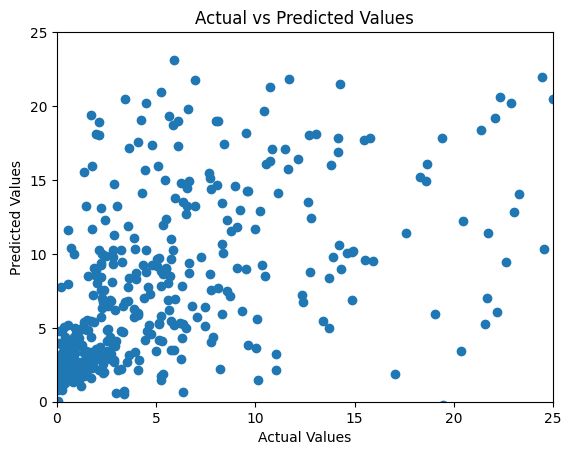

In [22]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()
